In [1]:
import deco
import numpy
import untangle
import matplotlib

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [2]:
# Globals
precision = numpy.float32
xml_file = "profiles/oker3_dr5.uddf"

In [3]:
doc = untangle.parse(xml_file)

In [4]:
data = numpy.zeros(
    len(doc.uddf.profiledata.repetitiongroup.dive.samples.waypoint),
    dtype=[('time', precision), ('depth', precision),
           ('calculated_ppo2', precision), ('measured_ppo2', precision), ('ppo2_drop', precision),
           ('calculated_fo2', precision), ('measured_fo2', precision), ('fo2_drop', precision),
           ('predicted_fo2', precision)
           ])

In [5]:
gasmixes = dict()

for mix in doc.uddf.gasdefinitions.mix:
    gasmixes.update({ mix['id']: {
        'f_he': float(mix.he.cdata),
        'f_o2': float(mix.o2.cdata),
        'f_n2': 1 - float(mix.o2.cdata) - float(mix.he.cdata) }})

print(gasmixes)

{'mix0': {'f_he': 0.0, 'f_o2': 0.2, 'f_n2': 0.8}, 'mix1': {'f_he': 0.0, 'f_o2': 1.0, 'f_n2': 0.0}, 'mix2': {'f_he': 0.234, 'f_o2': 0.516, 'f_n2': 0.24999999999999997}, 'mix3': {'f_he': 0.0, 'f_o2': 0.31, 'f_n2': 0.69}, 'mix4': {'f_he': 0.34, 'f_o2': 0.34, 'f_n2': 0.3199999999999999}, 'mix5': {'f_he': 0.4, 'f_o2': 0.25, 'f_n2': 0.35}, 'mix6': {'f_he': 0.44, 'f_o2': 0.18, 'f_n2': 0.38000000000000006}, 'mix7': {'f_he': 0.55, 'f_o2': 0.15, 'f_n2': 0.29999999999999993}, 'mix8': {'f_he': 0.64, 'f_o2': 0.11, 'f_n2': 0.25}, 'mix9': {'f_he': 0.69, 'f_o2': 0.1, 'f_n2': 0.21000000000000008}, 'mix10': {'f_he': 0.8, 'f_o2': 0.07, 'f_n2': 0.1299999999999999}}


In [6]:
# Constants for stable fo2 predition calculation
R = 1 / 8
k = 20

# Initialize decompression context
try:
    p_surface_in = float(doc.uddf.profiledata.repetitiongroup.dive.informationbeforedive.surfacepressure.cdata) / 100000
except:
    p_surface_in = 1.0

settings = deco.deco_settings(
    gf_low = 0.1,
    gf_high = 0.90)

ctx = deco.deco_zhl16b(
    settings=settings,
    p_surface = p_surface_in)

# Read profile
i = 0
lasttime = 0
for waypoint in doc.uddf.profiledata.repetitiongroup.dive.samples.waypoint:
    try:
        activemix = waypoint.switchmix['ref']
    except:
        activemix
    time = float(waypoint.divetime.cdata) / 60.0
    depth = float(waypoint.depth.cdata)
    p_ambient = ctx.depth_to_pressure(depth)
    data[i]['time'] = time
    data[i]['depth'] = -depth
    data[i]['calculated_ppo2'] = p_ambient * gasmixes[activemix]['f_o2']
    data[i]['calculated_fo2'] = gasmixes[activemix]['f_o2']
    
    try:
        data[i]['measured_ppo2'] = float(waypoint.measuredpo2.cdata) / 100000
    except:
        try:
            data[i]['measured_ppo2'] = data[i - 1]['measured_ppo2']
        except:
            data[i]['measured_ppo2'] = -1

    data[i]['measured_fo2'] = data[i]['measured_ppo2'] / p_ambient
    data[i]['ppo2_drop'] = data[i]['calculated_ppo2'] - data[i]['measured_ppo2']
    data[i]['fo2_drop'] = data[i]['calculated_fo2'] - data[i]['measured_fo2']
    
    data[i]['predicted_fo2'] = ((p_ambient * R * k + 1) * gasmixes[activemix]['f_o2'] - 1)/ (p_ambient * R * k)

    i += 1
    lasttime = time
    

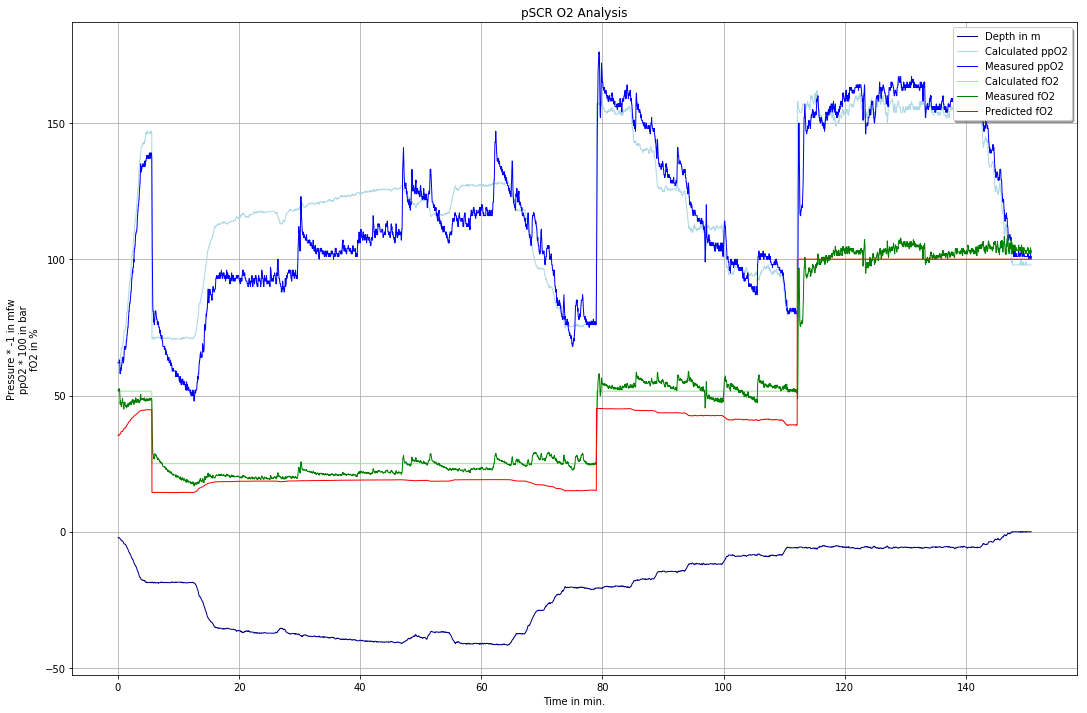

In [7]:
fig, ax = matplotlib.pyplot.subplots(figsize = (18, 12))

matplotlib.pyplot.title('pSCR O2 Analysis')

matplotlib.pyplot.xlabel('Time in min.')

matplotlib.pyplot.ylabel('Pressure * -1 in mfw\nppO2 * 100 in bar\nfO2 in %')

ax.plot(
    data['time'],
    data['depth'],
    label = 'Depth in m',
    color = 'darkblue',
    lw = 1)

ax.plot(
    data['time'],
    data['calculated_ppo2'] * 100,
    label = 'Calculated ppO2',
    color = 'lightblue',
    lw = 1)

ax.plot(
    data['time'],
    data['measured_ppo2'] * 100,
        label = 'Measured ppO2',
    color = 'blue',
    lw = 1)

ax.plot(
    data['time'],
    data['calculated_fo2'] * 100,
    label = 'Calculated fO2',
    color = 'lightgreen',
    lw = 1)

ax.plot(
    data['time'],
    data['measured_fo2'] * 100,
    label = 'Measured fO2',
    color = 'green',
    lw = 1)

ax.plot(
    data['time'],
    data['predicted_fo2'] * 100,
    label = 'Predicted fO2',
    color = 'red',
    lw = 1)

legend = ax.legend(loc = 'upper right', shadow = True)

ax.grid()
